In [1]:
import os
import requests
import geopandas as gpd
from requests.auth import HTTPBasicAuth
from shapely.geometry import shape
import numpy as np
import subprocess
import json
import pathlib
import pandas as pd
headers = {'Content-Type': 'application/json'}

############# SET THESE VARIABLES ######################
# redefined based on the filter you want to use

from geojson_TST import domain # This is the geojson polygon for the border (rectangle) of the Budd Creak watershed
# from geojson_TUO import domain # This is the geojson polygon (rectangle) for the larger upper Tuolumne River
# from geojson_BUD import domain # This is the geojson polygon (not retangle) for the unclipped Budd Creek watershed

domainID = 'TST'

# enter the Planet user API key
apiKey = ''
item_type = "PSScene"
asset_type = "ortho_analytic_4b_sr"
bundle_type = "analytic_sr_udm2"

# data download location
out_direc = '/home/etboud/projects/data/planet/'
#out_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/'
############# DON'T CHANGE VARIABLES BEYOND THIS ############

In [2]:
############ FUNCTIONS. DON'T CHANGE THESE!!! #########
def build_payload(item_ids, item_type, bundle_type, aoi_coordinates):
    payload = {
        "name": item_ids[0],
        "source_type": "scenes",
        "products": [
            {
                "item_ids": item_ids,
                "item_type": item_type,
                "product_bundle": bundle_type
            }
        ],
        "tools": [
            {
                "clip": {
                    "aoi": {
                        "type": "Polygon",
                        "coordinates": aoi_coordinates
                    }
                }
            }
        ]
    }
    return payload

def order_now(payload,apiKey):
    orders_url = 'https://api.planet.com/compute/ops/orders/v2'
    response = requests.post(orders_url, data=json.dumps(payload), auth=HTTPBasicAuth(apiKey, ''), headers=headers)
    print(response)

    if response.status_code==202:
        order_id =response.json()['id']
        url = f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
        # feature_check = requests.get(url, auth=(PLANET_API_KEY, ""))
        feature_check = requests.get(url, auth=HTTPBasicAuth(apiKey, ''))
        if feature_check.status_code==200:
            print(f"Submitted a total of {len(feature_check.json()['products'][0]['item_ids'])} image ids: accepted a total of {len(feature_check.json()['products'][0]['item_ids'])} ids")
            print(f"Order URL: https://api.planet.com/compute/ops/orders/v2/{order_id}")
            return f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
    else:
        print(f'Failed with Exception code : {response.status_code}')
        
def download_results(order_url,folder, overwrite=False):
    r = requests.get(order_url, auth=HTTPBasicAuth(apiKey, ''))
    try:
        if r.status_code ==200:
            response = r.json()
            results = response['_links']['results']
            results_urls = [r['location'] for r in results]
            results_names = [r['name'] for r in results]
            print('{} items to download'.format(len(results_urls)))

            for url, name in zip(results_urls, results_names):
                path = pathlib.Path(os.path.join(folder,name))

                if overwrite or not path.exists():
                    print('downloading {} to {}'.format(name, path))
                    r = requests.get(url, allow_redirects=True)
                    path.parent.mkdir(parents=True, exist_ok=True)
                    open(path, 'wb').write(r.content)
                else:
                    print('{} already exists, skipping {}'.format(path, name))
        else:
            print(f'Failed with response {r.status_code}')
    except:
        print('data not ready yet')
    r.close()
    # except Exception as e:
    #     print(e)
    #     print(order_url)
    #     raise Exception
    # r.close()

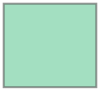

In [3]:
# ensure that the domain shape makes sense
domain_geometry = shape(domain['config'][0]['config'])
domain_geometry

In [4]:
# Search API request object
search_endpoint_request = {
  "item_types": [item_type],
  "filter": domain
}
result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(apiKey, ''),
    json=search_endpoint_request)

In [5]:
# view available data and prepare the list of planet IDs to download
geojson_data = result.json()
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Add a new column to 'gdf' with the intersection area
gdf['intersection_area'] = gdf['geometry'].intersection(domain_geometry).area

# Calculate the percentage overlap
gdf['overlap_percentage'] = (gdf['intersection_area'] / domain_geometry.area) * 100

gdf

,geometry,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,...,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent,intersection_area,overlap_percentage
0,"POLYGON ((-119.18325 37.99466, -119.23144 37.8...",2023-04-19T18:23:15.439185Z,0,73,13,0.00,0,True,3.7,0,...,85,6446682,135.6,56.1,2024-01-17T08:21:51Z,5.0,67,100,0.002478,5.478067
1,"POLYGON ((-119.23375 37.83074, -119.28446 37.6...",2023-05-30T17:51:53.747485Z,0,90,34,0.01,1,True,3.9,0,...,65,6545108,112.2,59.1,2023-05-31T07:00:58Z,3.3,70,99,0.004674,10.331251
2,"POLYGON ((-119.45300 37.76888, -119.50022 37.5...",2023-05-29T18:28:09.664931Z,0,78,9,0.03,3,True,3.7,0,...,88,6542620,124.4,65.4,2023-06-02T23:19:18Z,0.9,78,97,0.001834,4.054306
3,"POLYGON ((-119.47644 38.10401, -119.52284 37.9...",2023-05-28T17:44:26.853422Z,0,62,18,0.05,4,True,3.6,1,...,75,6540521,111.1,57.4,2023-06-01T02:25:36Z,1.6,59,95,0.009456,20.903582
4,"POLYGON ((-119.51341 37.96943, -119.55958 37.8...",2023-05-28T17:44:28.987246Z,0,51,13,0.05,4,True,3.6,1,...,81,6540521,110.8,57.5,2023-06-01T02:25:36Z,1.6,58,95,0.039028,86.274368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,"POLYGON ((-119.44246 37.84553, -119.48717 37.6...",2023-04-04T18:10:48.746315Z,0,49,3,0.05,5,True,3.5,0,...,92,6408503,134.7,49.3,2023-04-05T09:58:42Z,5.0,66,95,0.018827,41.618985
165,"POLYGON ((-119.51792 37.90030, -119.57001 37.7...",2023-04-04T17:49:22.053582Z,0,49,6,0.05,5,True,4.0,0,...,89,6408212,129.3,46.7,2023-04-06T01:29:44Z,5.2,66,95,0.028211,62.362198
166,"POLYGON ((-119.47873 38.04662, -119.52983 37.8...",2023-04-04T17:49:19.706259Z,0,61,2,0.03,3,True,4.0,0,...,95,6408212,129.5,46.6,2023-04-06T01:29:44Z,5.2,76,97,0.026829,59.308118
167,"POLYGON ((-119.71400 37.88675, -119.76206 37.7...",2023-04-02T18:22:36.836613Z,0,78,6,0.01,1,True,3.7,0,...,93,6403240,139.8,50.5,2023-04-03T03:57:01Z,4.8,78,99,0.005863,12.959793


In [9]:
# prep the ID and geometry lists
id_list = [feature['id'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 89]
geom_list = [feature['geometry'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 89]
print(len(id_list))
print(sorted(id_list))

1
['20230429_174945_39_24af']


In [ ]:
### ONLY RUN THIS CELL IF YOU WANT TO CHECK ON ORDER STATUS

# # see the status of the requested tiles. Are they "active"?
# for IDD in id_list:
#     print(IDD)
#     command = 'curl -L -H "Authorization: api-key '+apiKey+'"'
#     sublink = " 'https://api.planet.com/data/v1/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     # sublink = " 'https://api.planet.com/data/v2/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     command = command+sublink+'| jq .'+asset_type+'.status'
#     status = subprocess.run(command, shell=True)
#     print(command)
#     # break

In [10]:
# prepare and submit the orders
order_urls = pd.DataFrame(columns = ["index","ID_geom", "order_url"])

# loop through each order payload, and submit
for idx,IDD in enumerate(id_list):
    print(idx,IDD)
    
    payload = build_payload([IDD],item_type,bundle_type,domain['config'][0]['config']['coordinates'])
    order_url = order_now(payload,apiKey)
    
    order_urls.loc[idx, "index"] = idx        
    order_urls.loc[idx, "ID_geom"] = IDD
    order_urls.loc[idx, "order_url"] = order_url

0 20230429_174945_39_24af
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/dae681bc-29b2-48c7-a523-d134a4fd3095


In [11]:
# check out the data, save to a csv if you want to come back later
print(order_urls)
order_urls.to_csv('urlSaver.csv', index = None)# save all URLs

  index                  ID_geom  \
0     0  20230429_174945_39_24af   

                                           order_url  
0  https://api.planet.com/compute/ops/orders/v2/d...  


In [14]:
# download the orders once ready
# outputs of "data not ready yet" mean that the orders need more time to process before downloading
for url in order_urls.itertuples():
    print(url.index,url.order_url)
    print("start downloading data to".format(), out_direc + url.ID_geom)
    if url.order_url != None:
        try:
            nantest = ~np.isnan(url.order_url)
        except:
            download_results(url.order_url,folder = out_direc + url.ID_geom)
    # break

0 https://api.planet.com/compute/ops/orders/v2/dae681bc-29b2-48c7-a523-d134a4fd3095
start downloading data to /home/etboud/projects/data/planet/20230429_174945_39_24af
5 items to download
downloading dae681bc-29b2-48c7-a523-d134a4fd3095/PSScene/20230429_174945_39_24af_metadata.json to /home/etboud/projects/data/planet/20230429_174945_39_24af/dae681bc-29b2-48c7-a523-d134a4fd3095/PSScene/20230429_174945_39_24af_metadata.json
downloading dae681bc-29b2-48c7-a523-d134a4fd3095/PSScene/20230429_174945_39_24af_3B_udm2_clip.tif to /home/etboud/projects/data/planet/20230429_174945_39_24af/dae681bc-29b2-48c7-a523-d134a4fd3095/PSScene/20230429_174945_39_24af_3B_udm2_clip.tif
downloading dae681bc-29b2-48c7-a523-d134a4fd3095/PSScene/20230429_174945_39_24af_3B_AnalyticMS_metadata_clip.xml to /home/etboud/projects/data/planet/20230429_174945_39_24af/dae681bc-29b2-48c7-a523-d134a4fd3095/PSScene/20230429_174945_39_24af_3B_AnalyticMS_metadata_clip.xml
downloading dae681bc-29b2-48c7-a523-d134a4fd3095/PSSc